In [1]:
import numpy as np
import torch
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from dataclasses import dataclass
import random
from enviroments import env_red_toy, env_red2
import pickle
from algorithms.Action_Gen import Action_generation
from algorithms.RDQL import RDQL_algorithm
import time

NUMERO_DE_NUCLEOS = 32

torch.set_num_threads(NUMERO_DE_NUCLEOS)


In [2]:
name_exp = "Exp6"
Red_name = "red2"
Demand_Model = "Exp" #Puede ser EXP/MNL
Qfun_model = "AG" #Puede ser LR/NN

In [3]:
T = 1000

env = env_red2()

#Hiperarametros del algoritmo
gamma = 1
alpha = 1e-3
eps = 1.0
n = 1
eps_decay = 0.999997**(1/(n*(env.T/50)))
#T=50 eps_decay = 0.999997**(1/n)
batch_size = 200

#Tamaño de la ejecución
max_episodes = 70000*n
max_steps = T

#Tamaño del bufer
buffer_size = 10_000

#Hiperparametros del modelo
nA_initial = 5
exp_layers =[
    [128,128],
    [64,64]
]

In [4]:
R_exp = []
time_exp = []
qfun_exp = []
a_space_exp = [] 

for i, num_hiddens in enumerate(exp_layers):

    print(f"Experimento {i}:")

    start_time = time.time()
    qnet, env, R_over = RDQL_algorithm(max_episodes,max_steps,buffer_size, env,eps_decay,gamma,batch_size,alpha, nA_initial,num_hiddens)
    end_time = time.time()
    execution_time = end_time - start_time

    R_exp.append(R_over)
    time_exp.append(execution_time)
    qfun_exp.append(qnet)
    a_space_exp.append(env.action_space)

Experimento 0:


In [ ]:
import os
# Asegurarse de que el directorio exista, si no existe, créalo
directory = "results/" + name_exp
if not os.path.exists(directory):
    os.makedirs(directory)


exp = {}
exp["R_exp"] = R_exp
exp["Time_exp"] = time_exp
exp["qfun_exp"] = qfun_exp
exp["a_space_exp"] = a_space_exp

with open("results/"+ name_exp +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'wb') as f:
    pickle.dump(exp, f)

In [ ]:
with open("results/"+ name_exp +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'rb') as f:
    exp = pickle.load(f)

R_exp = exp["R_exp"]
time_exp = exp["Time_exp"]
qfun_exp = exp["qfun_exp"]
a_space_exp = exp["a_space_exp"] 

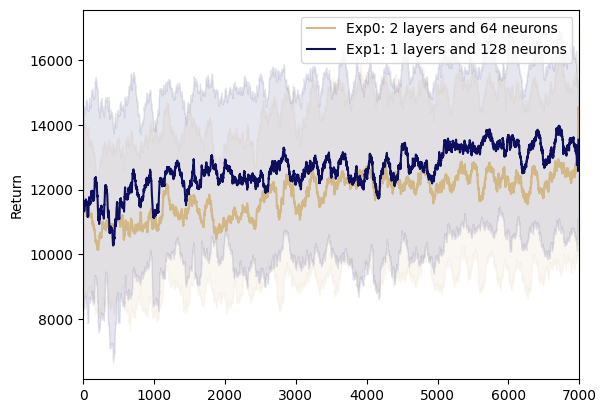

In [ ]:
num_plots = len(R_exp)  # Número de gráficas
colors = ['#' + ''.join(np.random.choice(list('0123456789ABCDEF'), size=6)) for _ in range(num_plots)]

for i, R_over in enumerate(R_exp):

    for j, R in enumerate(R_over[len(R_over)-1:]):

        Rs= R[:20000]
        mean = np.array([np.mean(Rs[i:i+100]) for i in range(len(Rs) - 10)])
        std = np.array([np.std(Rs[i:i+100]) for i in range(len(Rs) - 10)])
        time = np.arange(mean.size)
        plt.plot(mean,color=colors[i],label= f"Exp{i}: {len(exp_layers[i])} layers and {exp_layers[i][0]} neurons")
        plt.fill_between(time, mean - std, mean + std, color=colors[i], alpha=0.1)

        plt.xlim(0, len(Rs))
        plt.grid()
        plt.ylabel("Return")
        plt.legend()

plt.savefig("results/"+ name_exp +"/Returns_" +Demand_Model + "_" + Qfun_model +"_" + Red_name +".png")

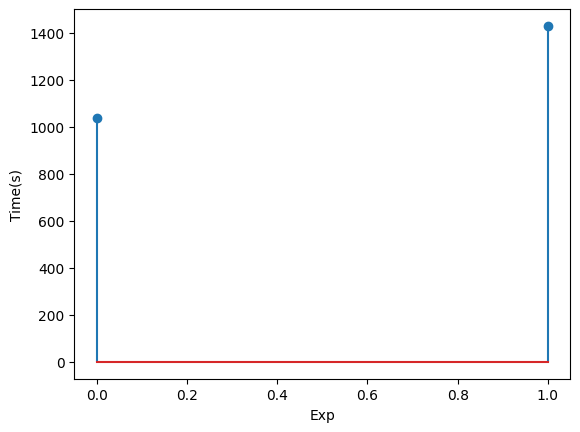

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.stem(time_exp)
plt.xlabel("Exp")
plt.ylabel("Time(s)")
plt.show()

plt.savefig("results/"+ name_exp +"/Time_" +Demand_Model + "_" + Qfun_model +"_" + Red_name +".png")

MovieWriter imagemagick unavailable; using Pillow instead.


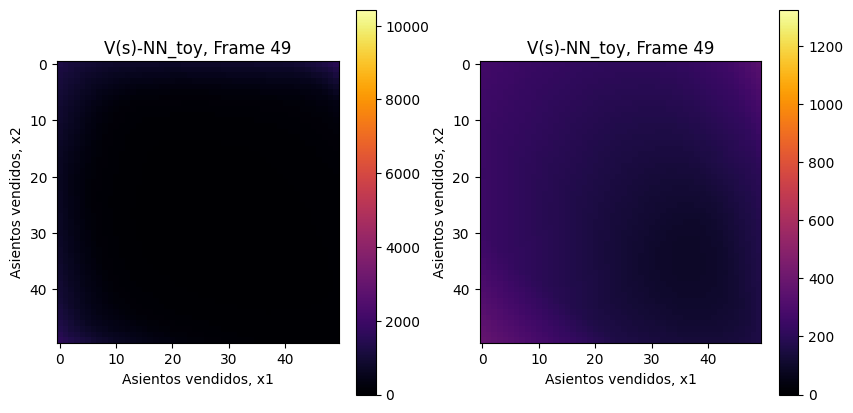

In [ ]:
from algorithms.utils import saveGIFT

saveGIFT(env, qfun_exp, "NN", [0,1], "results/"+ name_exp +"/Qfun_" +Demand_Model + "_" + Qfun_model +"_" + Red_name +".gif")

In [ ]:
from algorithms.utils import compare_Qfun_exp

name = "results/"+ name_exp +"/SelfQfunDiff_" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".png"
diff_matrix = compare_Qfun_exp(env,qfun_exp,Qfun_model,name)